In [1]:
!pip -q install ./python
import numpy as np
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import torch
import dqn_agent
import utils
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="/Banana_Linux/Banana.x86_64")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.36 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [2]:
def dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores_file_ptr = open("scores.out", "w")
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_file_ptr.write("{}\n".format(score))
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
            
    utils.save_model_params(i_episode, agent, scores)
            
    scores_file_ptr.close()
    return scores


Episode 100	Average Score: 0.27
Episode 200	Average Score: 3.23
Episode 300	Average Score: 6.58
Episode 400	Average Score: 10.34
Episode 500	Average Score: 11.88
Episode 600	Average Score: 13.06
Episode 700	Average Score: 14.11
Episode 800	Average Score: 14.58
Episode 900	Average Score: 14.69
Episode 1000	Average Score: 14.34
Episode 1100	Average Score: 14.49
Episode 1200	Average Score: 15.73
Episode 1300	Average Score: 15.26
Episode 1400	Average Score: 15.20
Episode 1500	Average Score: 14.61
Episode 1600	Average Score: 15.19
Episode 1700	Average Score: 15.62
Episode 1800	Average Score: 13.49
Episode 1900	Average Score: 15.78
Episode 2000	Average Score: 14.16


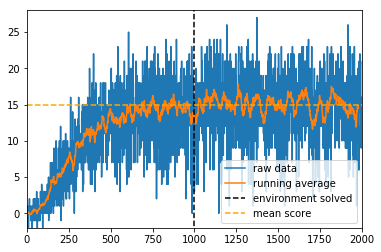

In [3]:
def main():
    BUFFER_SIZE = int(1e5)  # replay buffer size
    BATCH_SIZE = 64         # minibatch size
    GAMMA = 0.99            # discount factor
    TAU = 1e-3              # for soft update of target parameters
    LR = 5e-4               # learning rate 
    UPDATE_EVERY = 4        # how often to update the network
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    network_params = (BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR, UPDATE_EVERY)
    
    rand_seed = random.randrange(10000)
    agent = dqn_agent.Agent(state_size=37, action_size=4, seed=rand_seed, 
                            device=device, network_params=network_params)
    scores = dqn(agent)
    utils.plot_results(data=scores)

if __name__ == "__main__":
    main()

In [4]:
env.close()